## Cash Flow Forecasting

In this notebook I try to predict future cash flow using machine learning models

I will test a few different models and see which one works the best

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

np.random.seed(101)

## Load Data

In [2]:
data = pd.read_csv('simulated_cashflow_data.csv')
print(f"Data loaded: {data.shape}")
data.head()

Data loaded: (120, 15)


,Month,Year,Revenue,Recession,AR_Delay,Other_Expenses,COGS,OPEX_Variable,OPEX_Fixed,Total_Expenses,Cash_Collected,Net_Cash_Flow,Cash_Start,Cash_End,Shortage_Alert
0,1,1,55180.384905,0,0,1017,27590.192452,5518.038490,15000,49125.230943,55180.384905,6055.0,100000.0,106055.0,0
1,2,1,50706.675869,0,2,1143,25353.337934,5070.667587,15000,46567.005521,0.000000,-46567.0,106055.0,59488.0,0
2,3,1,40756.268038,0,3,788,20378.134019,4075.626804,15000,40241.760823,0.000000,-40242.0,59488.0,19246.0,0
3,4,1,44379.455734,0,2,1013,22189.727867,4437.945573,15000,42640.673440,50706.675869,8066.0,19246.0,27312.0,0
4,5,1,62223.323780,0,3,1865,31111.661890,6222.332378,15000,54198.994268,50706.675869,-3492.0,27312.0,23820.0,0


## Create Features

I need to create some features to help the model predict. Firstly, past revenue (what happened 1, 2, 3 months ago). Secondly, past cash flow. Finally, average of last few months.

In [3]:
# Create lag features (past values)
data['Revenue_lag1'] = data['Revenue'].shift(1)
data['Revenue_lag2'] = data['Revenue'].shift(2)
data['Revenue_lag3'] = data['Revenue'].shift(3)

data['CashFlow_lag1'] = data['Net_Cash_Flow'].shift(1)
data['CashFlow_lag2'] = data['Net_Cash_Flow'].shift(2)
data['CashFlow_lag3'] = data['Net_Cash_Flow'].shift(3)

# Rolling averages
data['Revenue_avg3'] = data['Revenue'].rolling(3).mean()
data['Revenue_avg6'] = data['Revenue'].rolling(6).mean()
data['CashFlow_avg3'] = data['Net_Cash_Flow'].rolling(3).mean()

# Month of year (for seasonality)
data['Month_num'] = data['Month'] % 12
data['Month_num'] = data['Month_num'].replace(0, 12)

# Drop rows with missing values
data_clean = data.dropna()
print(f"Data after cleaning: {data_clean.shape}")

Data after cleaning: (115, 25)


## Prepare Train and Test Sets

I use first 24 months for training and last 6 months for testing

In [4]:
# Features I want to use
feature_cols = ['Revenue', 'COGS', 'OPEX_Fixed', 'OPEX_Variable', 'Other_Expenses', 'AR_Delay',
                'Revenue_lag1', 'Revenue_lag2', 'Revenue_lag3',
                'CashFlow_lag1', 'CashFlow_lag2', 'CashFlow_lag3',
                'Revenue_avg3', 'Revenue_avg6', 'CashFlow_avg3',
                'Month_num']

# What I want to predict
target = 'Net_Cash_Flow'

X = data_clean[feature_cols]
y = data_clean[target]

# Split into train and test (I use time based, not random)
train_size = 24
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# Save cash_start for later
cash_start_test = data_clean['Cash_Start'].iloc[train_size:].values
actual_cash_end_test = data_clean['Cash_End'].iloc[train_size:].values

print(f"Training: {len(X_train)} months")
print(f"Testing: {len(X_test)} months")

Training: 24 months
Testing: 91 months


## Model 1 : Random Forest

I like this model personally becasue this model can capture complex patterns

In [5]:
# Training our model
rf_model = RandomForestRegressor(n_estimators=100, 
                                 max_depth=10, 
                                 random_state=101)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [6]:
# Predict
rf_pred = rf_model.predict(X_test)

# Calculate cash position
rf_pred_cash = []
for i in range(len(cash_start_test)):
    cash_end = cash_start_test[i] + rf_pred[i]
    rf_pred_cash.append(cash_end)

In [7]:
# Calculate errors
rf_mae = mean_absolute_error(actual_cash_end_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(actual_cash_end_test, rf_pred))

print("Random Forest Results:")
print(f"  MAE: ${rf_mae: }")
print(f"  RMSE: ${rf_rmse: }")

Random Forest Results:
  MAE: $ 273893.8320879121
  RMSE: $ 280690.3810420657


## Model 2 : XGBoost

Another tree-based model that usually performs well

In [8]:
# Train model
xgb_model = XGBRegressor(n_estimators=100, 
                         max_depth=5, 
                         learning_rate=0.1, 
                         random_state=101)
xgb_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [9]:
# Predict
xgb_pred = xgb_model.predict(X_test)

# Calculate cash position
xgb_pred_cash = []
for i in range(len(cash_start_test)):
    cash_end = cash_start_test[i] + xgb_pred[i]
    xgb_pred_cash.append(cash_end)

In [10]:
# Calculate errors
xgb_mae = mean_absolute_error(actual_cash_end_test, xgb_pred_cash)
xgb_rmse = np.sqrt(mean_squared_error(actual_cash_end_test, xgb_pred_cash))

print("XGBoost Results:")
print(f"  MAE: ${xgb_mae: }")
print(f"  RMSE: ${xgb_rmse: }")

XGBoost Results:
  MAE: $ 5183.949035560691
  RMSE: $ 6345.706262968438


## Model 3 : LSTM Neural Network

This is a deep learning model designed for time series data although our data is too small for it and it may overfit; However I wanted to showcase its usage!

In [11]:
# Scale the data (LSTM works better with scaled data)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape for LSTM (needs 3D shape)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(f"LSTM data shape: {X_train_lstm.shape}")

LSTM data shape: (24, 1, 16)


In [12]:
# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
lstm_model.add(LSTM(50, activation='relu'))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train_lstm, y_train_scaled, epochs=40, batch_size=4, verbose=0)

D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
# Predict
lstm_pred_scaled = lstm_model.predict(X_test_lstm, verbose=0)
lstm_pred = scaler_y.inverse_transform(lstm_pred_scaled).flatten()

# Calculate cash position
lstm_pred_cash = []
for i in range(len(cash_start_test)):
    cash_end = cash_start_test[i] + lstm_pred[i]
    lstm_pred_cash.append(cash_end)

In [14]:
# Calculate errors
lstm_mae = mean_absolute_error(actual_cash_end_test, lstm_pred_cash)
lstm_rmse = np.sqrt(mean_squared_error(actual_cash_end_test, lstm_pred_cash))

print("LSTM Results:")
print(f"  MAE: ${lstm_mae: }")
print(f"  RMSE: ${lstm_rmse: }")

LSTM Results:
  MAE: $ 5556.629832257281
  RMSE: $ 7438.90205654459


## Compare All Models

Let's see which model performed best

In [15]:
# Create comparison table
results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LSTM'],
    'MAE': [rf_mae, xgb_mae, lstm_mae],
    'RMSE': [rf_rmse, xgb_rmse, lstm_rmse]
})

results = results.sort_values('MAE')

print("\nModel Comparison (lower is better):")
print(results.to_string(index=False))


Model Comparison (lower is better):
        Model           MAE          RMSE
      XGBoost   5183.949036   6345.706263
         LSTM   5556.629832   7438.902057
Random Forest 273893.832088 280690.381042


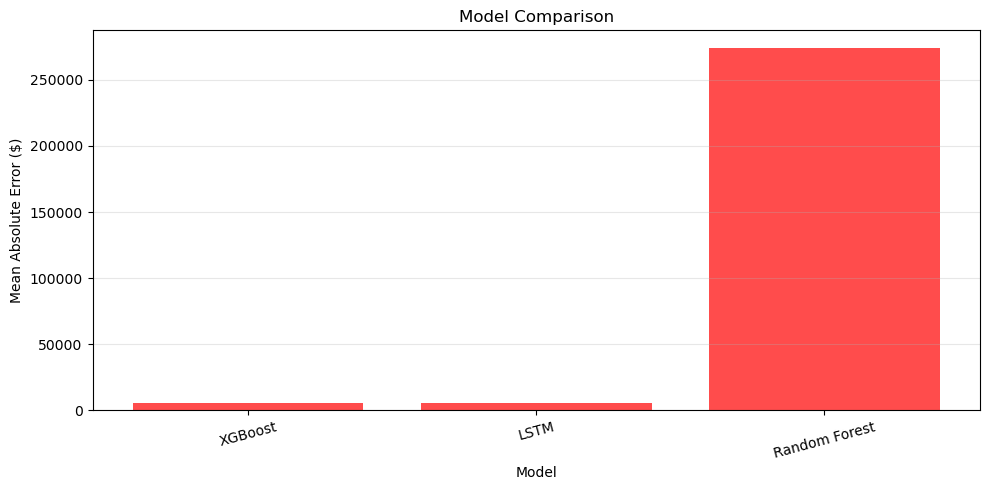

In [16]:
# Plot comparison
plt.figure(figsize=(10, 5))
plt.bar(results['Model'], results['MAE'], color='red', alpha=0.7)
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error ($)')
plt.title('Model Comparison')
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Visualize Predictions

Let's see how well the models predicted compared to actual values

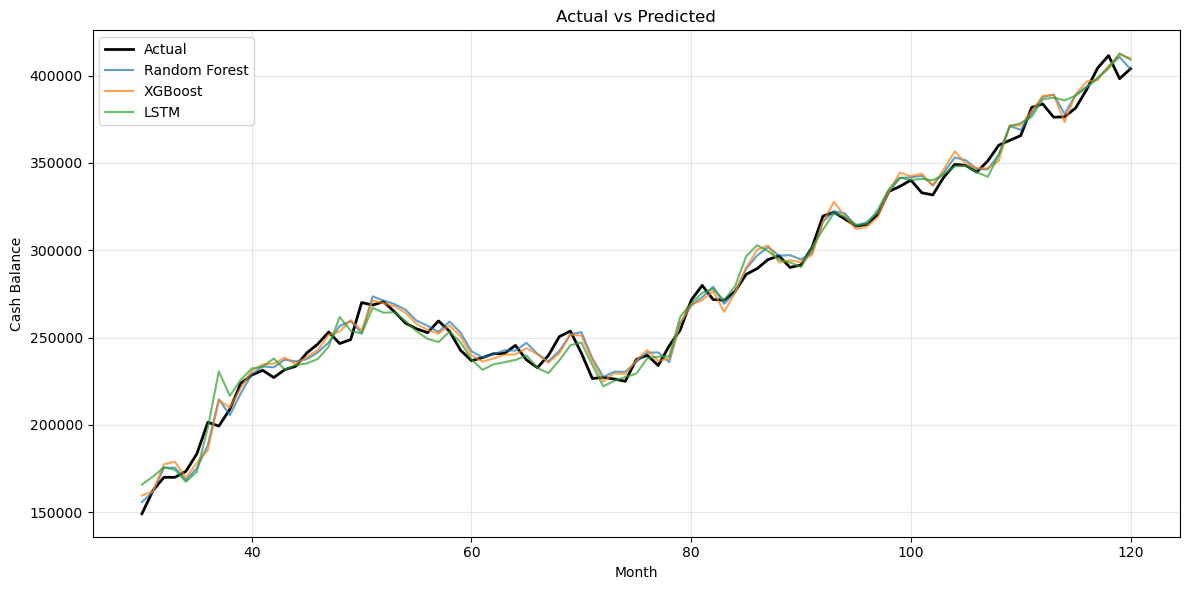

In [17]:
test_months = data_clean['Month'].iloc[train_size:].values

plt.figure(figsize=(12, 6))
plt.plot(test_months, actual_cash_end_test, linewidth=2, label='Actual', color='black')
plt.plot(test_months, rf_pred_cash, linewidth=1.5, label='Random Forest', alpha=0.7)
plt.plot(test_months, xgb_pred_cash, linewidth=1.5, label='XGBoost', alpha=0.7)
plt.plot(test_months, lstm_pred_cash, linewidth=1.5, label='LSTM', alpha=0.7)

plt.xlabel('Month')
plt.ylabel('Cash Balance')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Best Model

Based on the results, I can see which model worked best for predicting cash flow.

In [18]:
best_model_name = results.iloc[0]['Model']
best_mae = results.iloc[0]['MAE']

print(f"\nBest Model: {best_model_name}")
print(f"MAE: ${best_mae: }")
print(f"\nThis model can predict cash position with an average error of ${best_mae: }")


Best Model: XGBoost
MAE: $ 5183.949035560691

This model can predict cash position with an average error of $ 5183.949035560691


#### **Since the data is handmade and artificial, based on business logic, the high accuracy confirms that the models successfully learned the financial patterns and seasonal logic.**

## Summary

I tested 4 different models to predict cash flow:
1. Random Forest (tree-based)
2. XGBoost (advanced tree model)
3. LSTM (neural network for time series)

The models use past revenue, expenses, and cash flow to predict future values

This helps the company know when they might run low on cash and plan ahead